<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
가중합을 통해 seasonal output과 Linear output의 비율을 정해주었다

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [50]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [51]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [52]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [53]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [54]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [55]:
tup= (1,2)
len(tup)

2

In [56]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [57]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [58]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        self.Linear_Sum = nn.Linear(2,1)
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
#         print(season_output.size(),trend_output.size())
        SUM_OUTPUT = self.Linear_Sum(torch.cat([season_output,trend_output],dim=2))
        output = (SUM_OUTPUT)*div_factor
        
        return output,season_output,trend_output

In [59]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [60]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [61]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [62]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [63]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [64]:
torch.manual_seed(42)

In [65]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [66]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 2.561544200546062 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 1.729068832920608 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 1.1694390834404471 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 0.9843971440330289 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 0.8542593223368206 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 0.664366231393886 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 0.7814259704032896 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 0.6493390150564281 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 0.5737444033066073 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 0.5232838945880625 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 0.4820364937513021 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 0.5063190026146126 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 0.486548571127102 %
Adj

In [67]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.08583533404932808 %
SMAPE 0.006217284101310838 %
SMAPE 0.0070465676081425946 %
SMAPE 0.004618905744507629 %
SMAPE 0.00804970718718323 %
SMAPE 0.0075576529462324515 %
SMAPE 0.004737420221317734 %
SMAPE 0.012030251680926085 %
SMAPE 0.009021885601782742 %
SMAPE 0.003557958559895269 %
SMAPE 0.005424553132343135 %
SMAPE 0.005007103487969289 %
SMAPE 0.005091732702226182 %
SMAPE 0.012043028595144278 %
SMAPE 0.0038282149732253856 %
SMAPE 0.016213205542044307 %
SMAPE 0.009768040929373 %
SMAPE 0.013814012412694865 %
SMAPE 0.007857504392177361 %
SMAPE 0.003362117546828358 %
SMAPE 0.009146960104601476 %
SMAPE 0.005816885814965644 %
SMAPE 0.01854869561356054 %
SMAPE 0.007335315460210268 %
SMAPE 0.006500071762729931 %
SMAPE 0.009944753670410478 %
SMAPE 0.010661573956895154 %
SMAPE 0.007394702218540772 %
SMAPE 0.02058679681468334 %
SMAPE 0.01840314466237203 %
SMAPE 0.010907803096500857 %
SMAPE 0.004025213520193915 %
SMAPE 0.0045179279442493225 %
SMAPE 0.004341181531330562 %
SMAPE 0.0083057405

SMAPE 0.004767795232623939 %
SMAPE 0.011050034475942994 %
SMAPE 0.011912777557299137 %
SMAPE 0.02721732917241582 %
SMAPE 0.029170202319825474 %
SMAPE 0.011606591722710391 %
SMAPE 0.012875548412203843 %
SMAPE 0.006971726145138746 %
SMAPE 0.004617152150615311 %
SMAPE 0.005449900712235944 %
SMAPE 0.006510685003377148 %
SMAPE 0.008367327397365898 %
SMAPE 0.004914297143635338 %
SMAPE 0.008945153604827283 %
SMAPE 0.0080993407561607 %
SMAPE 0.00918663569484579 %
SMAPE 0.007946833120655583 %
SMAPE 0.0060360844188380725 %
SMAPE 0.004012851369481041 %
SMAPE 0.0029671187323287995 %
SMAPE 0.0052884530759058634 %
SMAPE 0.0042772377575204246 %
SMAPE 0.0077197423345296565 %
SMAPE 0.007273543506386204 %
SMAPE 0.006946972902710513 %
SMAPE 0.007689563795850063 %
SMAPE 0.0069771348694303015 %
SMAPE 0.008011094635378413 %
SMAPE 0.013675069450528099 %
SMAPE 0.006401537380270384 %
SMAPE 0.008238825578075648 %
SMAPE 0.008011761659190597 %
SMAPE 0.008642892369834954 %
SMAPE 0.014514925346560405 %
SMAPE 0.0232

SMAPE 0.010934350693332817 %
SMAPE 0.009375491783316647 %
SMAPE 0.0035586878257163335 %
SMAPE 0.004414402495740433 %
SMAPE 0.013886853155185008 %
SMAPE 0.006481425529329954 %
SMAPE 0.012171689882507053 %
SMAPE 0.008570080609302977 %
SMAPE 0.0029521759628323707 %
SMAPE 0.010564938640754917 %
SMAPE 0.007382119339126803 %
SMAPE 0.02113629390441929 %
SMAPE 0.02360495583593547 %
SMAPE 0.008759845135273281 %
SMAPE 0.007263025834191694 %
SMAPE 0.003095609776949004 %
SMAPE 0.006437860885171176 %
SMAPE 0.007790929736302132 %
SMAPE 0.005776473501100554 %
SMAPE 0.005773495757182445 %
SMAPE 0.006268020169216015 %
SMAPE 0.007423936307077383 %
SMAPE 0.0071892562397977144 %
SMAPE 0.006486502672487404 %
SMAPE 0.007131889948368553 %
SMAPE 0.005576102949419237 %
SMAPE 0.01182725527905859 %
SMAPE 0.009128183044140314 %
SMAPE 0.003582188706729994 %
SMAPE 0.011846687350725915 %
SMAPE 0.0023518904498871507 %
SMAPE 0.0096430166358914 %
SMAPE 0.010165727325329499 %
SMAPE 0.004496258950894116 %
SMAPE 0.0079917

SMAPE 0.006185602742789342 %
SMAPE 0.007650099136526478 %
SMAPE 0.0065418436128368285 %
SMAPE 0.018965765210850805 %
SMAPE 0.02471031432401105 %
SMAPE 0.0036381641618277176 %
SMAPE 0.00629979180519058 %
SMAPE 0.005228149234369539 %
SMAPE 0.010826750888099923 %
SMAPE 0.013941479146239999 %
SMAPE 0.010015228663860398 %
SMAPE 0.004161253272968679 %
SMAPE 0.0035525149188799787 %
SMAPE 0.008565539207467054 %
SMAPE 0.00591518561822113 %
SMAPE 0.010925436402430933 %
SMAPE 0.008448918825251894 %
SMAPE 0.002855044177920263 %
SMAPE 0.009458906492000096 %
SMAPE 0.008961359940485636 %
SMAPE 0.004956092685290514 %
SMAPE 0.009387013116310072 %
SMAPE 0.01190741152116459 %
SMAPE 0.0036455536057928835 %
SMAPE 0.0035095356758176877 %
SMAPE 0.004077303598435833 %
SMAPE 0.0055617385130517505 %
SMAPE 0.007542852913985598 %
SMAPE 0.0074723979688684486 %
SMAPE 0.004093651593301217 %
SMAPE 0.009261835038159916 %
SMAPE 0.007486103069481942 %
SMAPE 0.006086524680952721 %
SMAPE 0.012242808342307399 %
SMAPE 0.015

SMAPE 0.007066682648201096 %
SMAPE 0.01011096927146582 %
SMAPE 0.008505834242896526 %
SMAPE 0.012215595269481126 %
SMAPE 0.005517020860679622 %
SMAPE 0.004538347944617271 %
SMAPE 0.009237477619990386 %
SMAPE 0.009087780186121108 %
SMAPE 0.008553272169592674 %
SMAPE 0.016276701002752247 %
SMAPE 0.007208292867375121 %
SMAPE 0.004044571815498443 %
SMAPE 0.00544011992144533 %
SMAPE 0.008226609530282758 %
SMAPE 0.009087103397462215 %
SMAPE 0.004852429143397785 %
SMAPE 0.00812040022134397 %
SMAPE 0.011723914866706764 %
SMAPE 0.005099527217112154 %
SMAPE 0.008702027829713188 %
SMAPE 0.008559837230677658 %
SMAPE 0.003509134637852185 %
SMAPE 0.008219027788072708 %
SMAPE 0.01748085043050196 %
SMAPE 0.005387415041425925 %
SMAPE 0.00384680115143965 %
SMAPE 0.007065545492679348 %
SMAPE 0.008090499202126011 %
SMAPE 0.004989104410924483 %
SMAPE 0.0064382210771327655 %
SMAPE 0.002944516558500254 %
SMAPE 0.006421358563500235 %
SMAPE 0.00790882024784878 %
SMAPE 0.0037576256804641157 %
SMAPE 0.0110710070

SMAPE 0.012500449954131911 %
SMAPE 0.021090840872602712 %
SMAPE 0.010819789340075658 %
SMAPE 0.006987854388427196 %
SMAPE 0.005395732003165676 %
SMAPE 0.011194053046551744 %
SMAPE 0.011619472988570578 %
SMAPE 0.00627369401424005 %
SMAPE 0.004849625588349227 %
SMAPE 0.009425974381429114 %
SMAPE 0.010126462519522761 %
SMAPE 0.006693200572044589 %
SMAPE 0.010875702760557715 %
SMAPE 0.017615815332419515 %
SMAPE 0.009856864984726599 %
SMAPE 0.011457540103947395 %
SMAPE 0.005746729473521839 %
SMAPE 0.0032468724308643004 %
SMAPE 0.003778900778087291 %
SMAPE 0.006360734898549936 %
SMAPE 0.006627030522025734 %
SMAPE 0.005824616229801904 %
SMAPE 0.0050569165167644314 %
SMAPE 0.005398910207247809 %
SMAPE 0.006514670782109988 %
SMAPE 0.012676122811328128 %
SMAPE 0.0047531917945633495 %
SMAPE 0.006575034393108581 %
SMAPE 0.010632438919287779 %
SMAPE 0.015302094285289058 %
SMAPE 0.008684548531107339 %
SMAPE 0.00774520354843844 %
SMAPE 0.008619335861112631 %
SMAPE 0.0055524403173876635 %
SMAPE 0.0098

SMAPE 0.00412210531413848 %
SMAPE 0.005789012159993945 %
SMAPE 0.005849798335475498 %
SMAPE 0.0089601341307457 %
SMAPE 0.006324037853431719 %
SMAPE 0.005758967524229774 %
SMAPE 0.01023805384102161 %
SMAPE 0.006512024843189578 %
SMAPE 0.014195305645671398 %
SMAPE 0.00498678167193134 %
SMAPE 0.006741811771235007 %
SMAPE 0.0035950851643065103 %
SMAPE 0.0035689725391421234 %
SMAPE 0.006831589202477062 %
SMAPE 0.0035099561828246806 %
SMAPE 0.011970185035352188 %
SMAPE 0.007122966400686436 %
SMAPE 0.01058445928981655 %
SMAPE 0.007881631851489601 %
SMAPE 0.0064398884700267445 %
SMAPE 0.005218308476742095 %
SMAPE 0.006027671721085426 %
SMAPE 0.005852159793938938 %
SMAPE 0.005776236116901146 %
SMAPE 0.0033438738789186573 %
SMAPE 0.00408872282878292 %
SMAPE 0.008494106538364576 %
SMAPE 0.008639188608867698 %
SMAPE 0.004847282663945407 %
SMAPE 0.006906311016166455 %
SMAPE 0.008309862282658287 %
SMAPE 0.007977689125993948 %
SMAPE 0.007083433741172485 %
SMAPE 0.004031330214559148 %
SMAPE 0.00776978

SMAPE 0.023249357110898927 %
SMAPE 0.005107212281700413 %
SMAPE 0.008629718358179161 %
SMAPE 0.0028022492010677524 %
SMAPE 0.0027157644840372086 %
SMAPE 0.0061301631177741464 %
SMAPE 0.014201459451669509 %
SMAPE 0.013308272232194442 %
SMAPE 0.006105954737137154 %
SMAPE 0.007214456150904881 %
SMAPE 0.0067741888678938275 %
SMAPE 0.0065465959257835485 %
SMAPE 0.007662016891686107 %
SMAPE 0.0032835826952464227 %
SMAPE 0.004093467022812547 %
SMAPE 0.00874265774370997 %
SMAPE 0.005137019791675357 %
SMAPE 0.009521272144183968 %
SMAPE 0.018437171670178998 %
SMAPE 0.015513023563812567 %
SMAPE 0.012194704936518974 %
SMAPE 0.009667094408882804 %
SMAPE 0.004512930487237554 %
SMAPE 0.006785293528920988 %
SMAPE 0.006533927244802839 %
SMAPE 0.005107782612981282 %
SMAPE 0.004303056935732741 %
SMAPE 0.003412996709954541 %
SMAPE 0.00480089437485276 %
SMAPE 0.005222148017310246 %
SMAPE 0.007185960254787459 %
SMAPE 0.0034766028825856665 %
SMAPE 0.005532285635666767 %
SMAPE 0.004316115166169254 %
SMAPE 0.0

SMAPE 0.005573437819748506 %
SMAPE 0.012378647210653071 %
SMAPE 0.011641612767562037 %
SMAPE 0.010656354878165075 %
SMAPE 0.0045144617454440095 %
SMAPE 0.008984004869716955 %
SMAPE 0.006939978132777469 %
SMAPE 0.00686928974289458 %
SMAPE 0.004551973149148125 %
SMAPE 0.005050281712101423 %
SMAPE 0.008247396505225879 %
SMAPE 0.011818882510624462 %
SMAPE 0.004106491435891257 %
SMAPE 0.009127966858798686 %
SMAPE 0.007935418140448292 %
SMAPE 0.004923227588605528 %
SMAPE 0.006730351900529286 %
SMAPE 0.015497118114012665 %
SMAPE 0.01210692042059236 %
SMAPE 0.008399337822581288 %
SMAPE 0.005756674117264993 %
SMAPE 0.006266099005586057 %
SMAPE 0.005975179232336814 %
SMAPE 0.006831485418899774 %
SMAPE 0.007449892031900162 %
SMAPE 0.007018334284339289 %
SMAPE 0.005450866123069886 %
SMAPE 0.007520995256641072 %
SMAPE 0.008071753581248231 %
SMAPE 0.01776135821953062 %
SMAPE 0.012539213412310346 %
SMAPE 0.005767280170402955 %
SMAPE 0.004080310716972235 %
SMAPE 0.005750016643588651 %
SMAPE 0.00914853

SMAPE 0.010423173705021327 %
SMAPE 0.005002091189936664 %
SMAPE 0.005394214628125837 %
SMAPE 0.006321680972860123 %
SMAPE 0.00713299727328831 %
SMAPE 0.011221273247599584 %
SMAPE 0.00826385288291931 %
SMAPE 0.0047739906322732395 %
SMAPE 0.003045938193309894 %
SMAPE 0.006507347896331339 %
SMAPE 0.0057344688602825045 %
SMAPE 0.007801285218192788 %
SMAPE 0.006461570301922848 %
SMAPE 0.009344668466724215 %
SMAPE 0.008592654143285472 %
SMAPE 0.0044807771582497935 %
SMAPE 0.006336417968952902 %
SMAPE 0.0036086341538066335 %
SMAPE 0.01301211247965739 %
SMAPE 0.014333196300981399 %
SMAPE 0.0035649634490937387 %
SMAPE 0.01139812281326158 %
SMAPE 0.0034105333142520067 %
SMAPE 0.006645329582795512 %
SMAPE 0.010042852119568124 %
SMAPE 0.010313568667839945 %
SMAPE 0.014523203706943377 %
SMAPE 0.006697655565915284 %
SMAPE 0.0040859542602902366 %
SMAPE 0.0035646478236230905 %
SMAPE 0.009377030518407992 %
SMAPE 0.006560715561420239 %
SMAPE 0.00569342592416433 %
SMAPE 0.004189039148002394 %
SMAPE 0.003

SMAPE 0.004262615933612324 %
SMAPE 0.004805856200505332 %
SMAPE 0.0028837705969522176 %
SMAPE 0.008701741629124626 %
SMAPE 0.005803690106404247 %
SMAPE 0.005842487421432452 %
SMAPE 0.005280375621453004 %
SMAPE 0.011796204385063902 %
SMAPE 0.010794130720569228 %
SMAPE 7.304030142724514 %
SMAPE 9.623256526887417 %
SMAPE 10.673748172819614 %
SMAPE 9.536256074905396 %
SMAPE 1.186207561865558 %
SMAPE 0.01958638471978702 %
SMAPE 3.673387443646789 %
SMAPE 0.7589933754225058 %
SMAPE 0.1802046664868726 %
SMAPE 0.005068209696105441 %
SMAPE 0.006004039529287297 %
SMAPE 0.0020370765520283385 %
SMAPE 0.008312124289204803 %
SMAPE 0.013873503179581803 %
SMAPE 0.005565777963170149 %
SMAPE 0.006482087934159608 %
SMAPE 0.010578792388514557 %
SMAPE 0.005462170385868603 %
SMAPE 0.006803555101726034 %
SMAPE 0.004976674840975193 %
SMAPE 0.012087616389180766 %
SMAPE 0.014198946938051904 %
SMAPE 0.007149767786543748 %
SMAPE 0.006220564066666156 %
SMAPE 0.0036988688442534112 %
SMAPE 0.0019276018537084383 %
SMA

SMAPE 0.004264201434352799 %
SMAPE 0.005410496309650625 %
SMAPE 0.004965703547739508 %
SMAPE 0.003973525567175784 %
SMAPE 0.007953405730631857 %
SMAPE 0.004396824971763635 %
SMAPE 0.009343666082401114 %
SMAPE 0.005037768449597024 %
SMAPE 0.012822129198866605 %
SMAPE 0.004980543842975749 %
SMAPE 0.01198094842197861 %
SMAPE 0.0070709474568957376 %
SMAPE 0.008285495663585607 %
SMAPE 0.0067084763604725595 %
SMAPE 0.006877801117752825 %
SMAPE 0.003025261838274673 %
SMAPE 0.004888171163656807 %
SMAPE 0.004719388811615488 %
SMAPE 0.006318148894706609 %
SMAPE 0.00740617246697184 %
SMAPE 0.0035594928649516078 %
SMAPE 0.010888229772945124 %
SMAPE 0.009317366214418143 %
SMAPE 0.00628066007675443 %
SMAPE 0.01014948701049434 %
SMAPE 0.011946753446864022 %
SMAPE 0.005096755488295912 %
SMAPE 0.012443429269580975 %
SMAPE 0.006631907810692894 %
SMAPE 0.0033295681971594604 %
SMAPE 0.005551361310693892 %
SMAPE 0.011911230214650459 %
SMAPE 0.011914774393403604 %
SMAPE 0.004122420706266894 %
SMAPE 0.005972

SMAPE 0.010098280661679837 %
SMAPE 0.006266398973025388 %
SMAPE 0.007152661939414884 %
SMAPE 0.00998177763494823 %
SMAPE 0.004973584929757635 %
SMAPE 0.010663694553841196 %
SMAPE 0.007897469943031865 %
SMAPE 0.013776513225081997 %
SMAPE 0.005785807176835078 %
SMAPE 0.0030481956404670996 %
SMAPE 0.008131858392744107 %
SMAPE 0.01120202838728801 %
SMAPE 0.021511686847588862 %
SMAPE 0.011688256285424359 %
SMAPE 0.002122527112305761 %
SMAPE 0.007142571601718828 %
SMAPE 0.007993286889814044 %
SMAPE 0.01138393914709468 %
SMAPE 0.006123716980994232 %
SMAPE 0.02055965974560081 %
SMAPE 0.018192716589851443 %
SMAPE 0.005494456396263558 %
SMAPE 0.003542290323821362 %
SMAPE 0.020109268846454142 %
SMAPE 0.028621560519695773 %
SMAPE 0.022713410342021234 %
SMAPE 0.013627555056189067 %
SMAPE 0.007859694161879816 %
SMAPE 0.008728106018509152 %
SMAPE 0.005548764655486593 %
SMAPE 0.004896902925793256 %
SMAPE 0.01247638164907272 %
SMAPE 0.02230472132947625 %
SMAPE 0.017790442130262818 %
SMAPE 0.00960563866

SMAPE 0.009955922712151732 %
SMAPE 0.006622045265572751 %
SMAPE 0.007433189086611947 %
SMAPE 0.008943002389116828 %
SMAPE 0.0062756548053926045 %
SMAPE 0.006537197650459348 %
SMAPE 0.006356431216715919 %
SMAPE 0.007627957918238337 %
SMAPE 0.0054329938998307625 %
SMAPE 0.008945749141986425 %
SMAPE 0.0111650872820519 %
SMAPE 0.007207218261811476 %
SMAPE 0.008313290215710367 %
SMAPE 0.006450709916329345 %
SMAPE 0.011338398634237024 %
SMAPE 0.009954281748349558 %
SMAPE 0.01100651043407197 %
SMAPE 0.0047360509206555435 %
SMAPE 0.012412076230560842 %
SMAPE 0.003668091447138977 %
SMAPE 0.0073038491944998896 %
SMAPE 0.0086885088764177 %
SMAPE 0.003596313058352507 %
SMAPE 0.007565531237901268 %
SMAPE 0.004338385504560449 %
SMAPE 0.009750022306434403 %
SMAPE 0.017770476289626913 %
SMAPE 0.008263236638413218 %
SMAPE 0.0053382758935640595 %
SMAPE 0.011986959747559922 %
SMAPE 0.008771485415650204 %
SMAPE 0.011767792649607145 %
SMAPE 0.005943856937165037 %
SMAPE 0.006171363622897275 %
SMAPE 0.005856

SMAPE 0.008150935910066437 %
SMAPE 0.009543957299001704 %
SMAPE 0.008083862183866586 %
SMAPE 0.00810600181073795 %
SMAPE 0.009234800344586347 %
SMAPE 0.010271251590893371 %
SMAPE 0.007638880416720894 %
SMAPE 0.01200520629760149 %
SMAPE 0.007399044082376349 %
SMAPE 0.00707783025450226 %
SMAPE 0.008693563477947919 %
SMAPE 0.0074119888971608825 %
SMAPE 0.004536640756086285 %
SMAPE 0.008481825396017939 %
SMAPE 0.009534389041277791 %
SMAPE 0.00497593288207554 %
SMAPE 0.004291694319590533 %
SMAPE 0.004043024090634617 %
SMAPE 0.007838091428084226 %
SMAPE 0.011001762038176821 %
SMAPE 0.006733386042178325 %
SMAPE 0.0096142784808535 %
SMAPE 0.006179578807405051 %
SMAPE 0.01280781594732616 %
SMAPE 0.01645275025725823 %
SMAPE 0.01956117706367877 %
SMAPE 0.016044229239867036 %
SMAPE 0.006877151769458577 %
SMAPE 0.0049087687287396875 %
SMAPE 0.00618851088898964 %
SMAPE 0.0037065393397313078 %
SMAPE 0.004963485073957941 %
SMAPE 0.00907986648530823 %
SMAPE 0.005786674218541066 %
SMAPE 0.00673758691766

SMAPE 0.013889476430392733 %
SMAPE 0.024743935846345266 %
SMAPE 0.015562357643091216 %
SMAPE 0.0036613771923725835 %
SMAPE 0.010718738999003108 %
SMAPE 0.007704399306248888 %
SMAPE 0.004474151617728239 %
SMAPE 0.003518748995702481 %
SMAPE 0.007939999605213188 %
SMAPE 0.009299273207716396 %
SMAPE 0.009725241920932604 %
SMAPE 0.0025441090817182044 %
SMAPE 0.011047162905697405 %
SMAPE 0.007129027025882806 %
SMAPE 0.012032924611503404 %
SMAPE 0.014385520145879127 %
SMAPE 0.0077065432630831765 %
SMAPE 0.012591446884762547 %
SMAPE 0.0065365898010441015 %
SMAPE 0.0029958573844339753 %
SMAPE 0.013808764650093506 %
SMAPE 0.006582473030476876 %
SMAPE 0.004989836719552443 %
SMAPE 0.0035199760097839317 %
SMAPE 0.005401632915265964 %
SMAPE 0.012486616385785963 %
SMAPE 0.007917357669498415 %
SMAPE 0.007903982133740328 %
SMAPE 0.004858085546629809 %
SMAPE 0.004349887963144283 %
SMAPE 0.0057010472480669705 %
SMAPE 0.0057938679701976525 %
SMAPE 0.0036750804921155127 %
SMAPE 0.013366008631692237 %
SMAPE

SMAPE 0.003573482745139245 %
SMAPE 0.005721606751819763 %
SMAPE 0.003784615180265405 %
SMAPE 0.004950268875973052 %
SMAPE 0.008703426873125863 %
SMAPE 0.010677074367777095 %
SMAPE 0.005938751907820006 %
SMAPE 0.004097232938221396 %
SMAPE 0.003488577358666589 %
SMAPE 0.006058620371277357 %
SMAPE 0.008312565058986365 %
SMAPE 0.004592391344431235 %
SMAPE 0.016071704329306158 %
SMAPE 0.004240633553649786 %
SMAPE 0.013043538623151107 %
SMAPE 0.007248375582548761 %
SMAPE 0.04789863359837909 %
SMAPE 0.051080989656270503 %
SMAPE 0.011229612608133266 %
SMAPE 0.007183531374721497 %
SMAPE 0.021753174118316565 %
SMAPE 0.005741115885086856 %
SMAPE 0.010201982778653473 %
SMAPE 0.004478526777347724 %
SMAPE 0.3467056965637312 %
SMAPE 0.03182658813142325 %
SMAPE 0.006925588959461493 %
SMAPE 0.03245162534386736 %
SMAPE 0.04789345183706928 %
SMAPE 0.005888968162167885 %
SMAPE 0.014965968706746933 %
SMAPE 0.004860957736184446 %
SMAPE 0.012224299280859439 %
SMAPE 0.005455195983586236 %
SMAPE 0.006605808106

SMAPE 0.030223785873886303 %
SMAPE 0.009035671412647162 %
SMAPE 0.0043464451260604164 %
SMAPE 0.009238019433496447 %
SMAPE 0.018189219998561157 %
SMAPE 0.004638716469401061 %
SMAPE 0.017388534551173507 %
SMAPE 0.007181909704030431 %
SMAPE 0.013891054459691077 %
SMAPE 0.011979443683230784 %
SMAPE 0.010842562471452766 %
SMAPE 0.02296846425136323 %
SMAPE 0.0054440625089000605 %
SMAPE 0.012080613656507921 %
SMAPE 0.01569749341049942 %
SMAPE 0.007191478972117692 %
SMAPE 0.002905455310610705 %
SMAPE 0.028474636021826427 %
SMAPE 0.01675973564283595 %
SMAPE 0.01912626899627412 %
SMAPE 0.007265824063324545 %
SMAPE 0.004480302505015743 %
SMAPE 0.006881959139576566 %
SMAPE 0.025402025294511073 %
SMAPE 0.008933820932725212 %
SMAPE 0.02432407919252455 %
SMAPE 0.007758385417105273 %
SMAPE 0.012185515159671922 %
SMAPE 0.022027194483598578 %
SMAPE 0.010210910247280935 %
SMAPE 0.006259401442378021 %
SMAPE 0.018795834904949515 %
SMAPE 0.009631077087874473 %
SMAPE 0.007842021123906306 %
SMAPE 0.015370083

SMAPE 0.09344766156482365 %
SMAPE 0.020564943493198484 %
SMAPE 0.07293531858488222 %
SMAPE 0.030740530068896987 %
SMAPE 0.006041017475268973 %
SMAPE 0.061214210266058444 %
SMAPE 0.022266072727234132 %
SMAPE 0.054611591806860815 %
SMAPE 0.021185789704190938 %
SMAPE 0.03889139149538323 %
SMAPE 0.034864480587202706 %
SMAPE 0.08774357334390714 %
SMAPE 0.07593428437121474 %
SMAPE 0.02598540664303073 %
SMAPE 0.028599275552267045 %
SMAPE 0.03935642714711207 %
SMAPE 0.11301652799056683 %
SMAPE 0.03904641858180469 %
SMAPE 0.042079313762314996 %
SMAPE 0.06220452977504465 %
SMAPE 0.23563579339474927 %
SMAPE 0.046682350074888745 %
SMAPE 0.10347765189476377 %
SMAPE 0.06081564576834353 %
SMAPE 0.07613240176931413 %
SMAPE 0.1191089528424527 %
SMAPE 0.015396462745115969 %
SMAPE 0.048821848104864785 %
SMAPE 0.04005348784035334 %
SMAPE 0.03394179059796443 %
SMAPE 0.10326858762073243 %
SMAPE 0.1195577725076191 %
SMAPE 0.018939498906604513 %
SMAPE 0.13468542796567817 %
SMAPE 0.16415194894761953 %
SMAPE 0.

SMAPE 0.010474629966878979 %
SMAPE 0.01358687748863474 %
SMAPE 0.01390967745908256 %
SMAPE 0.013238778293043653 %
SMAPE 0.015307731281382074 %
SMAPE 0.011725056067461992 %
SMAPE 0.0033156328104269046 %
SMAPE 0.0061771665397145625 %
SMAPE 0.0119708842739783 %
SMAPE 0.017074798893986554 %
SMAPE 0.009664892011130632 %
SMAPE 0.012441204687377194 %
SMAPE 0.012137749733341252 %
SMAPE 0.021985891001349955 %
SMAPE 0.006395992961842011 %
SMAPE 0.005883868750601096 %
SMAPE 0.007415411310148557 %
SMAPE 0.014136802085829459 %
SMAPE 0.006860678577602641 %
SMAPE 0.01991329024440347 %
SMAPE 0.006186315054151236 %
SMAPE 0.006235922933228721 %
SMAPE 0.0037925041187634183 %
SMAPE 0.02303119129805964 %
SMAPE 0.014605105899136108 %
SMAPE 0.010922102704171266 %
SMAPE 0.005852374452160802 %
SMAPE 0.005321451207123573 %
SMAPE 0.008414623126981269 %
SMAPE 0.008708773056355312 %
SMAPE 0.014540946910408081 %
SMAPE 0.005109330746961405 %
SMAPE 0.02033207331646736 %
SMAPE 0.029854608606342477 %
SMAPE 0.0061128279

SMAPE 0.012009126159000516 %
SMAPE 0.011711457281307958 %
SMAPE 0.008129047830379932 %
SMAPE 0.012485586209322717 %
SMAPE 0.006271316582001418 %
SMAPE 0.010123492802563305 %
SMAPE 0.006462921495348439 %
SMAPE 0.012497275994235224 %
SMAPE 0.014048736565484886 %
SMAPE 0.018076327269682224 %
SMAPE 0.014894703819663844 %
SMAPE 0.004164632974429594 %
SMAPE 0.008816997739330645 %
SMAPE 0.004640312600656671 %
SMAPE 0.010862359467409988 %
SMAPE 0.009720502632717398 %
SMAPE 0.008860312355636779 %
SMAPE 0.006502578376057499 %
SMAPE 0.01250306142986801 %
SMAPE 0.010006172055859963 %
SMAPE 0.010091677473951677 %
SMAPE 0.01220473120645238 %
SMAPE 0.005125766837792867 %
SMAPE 0.004686526712362138 %
SMAPE 0.007777799035920907 %
SMAPE 0.021287535897954513 %
SMAPE 0.008717036466777017 %
SMAPE 0.02695111919439341 %
SMAPE 0.00459150700705635 %
SMAPE 0.01318130915853999 %
SMAPE 0.02233746041423501 %
SMAPE 0.02414886918825232 %
SMAPE 0.019242167860880954 %
SMAPE 0.017846496966967607 %
SMAPE 0.0157111525742

SMAPE 0.008694001277945063 %
SMAPE 0.011420807845979652 %
SMAPE 0.00359520448546391 %
SMAPE 0.0194857225472731 %
SMAPE 0.01591559496739592 %
SMAPE 0.00824162311208454 %
SMAPE 0.008413741610070247 %
SMAPE 0.005325639651800884 %
SMAPE 0.005813478950386752 %
SMAPE 0.011655325141589401 %
SMAPE 0.001947996998751478 %
SMAPE 0.006380090952006867 %
SMAPE 0.013227132418705878 %
SMAPE 0.007312138880138263 %
SMAPE 0.00549493180119498 %
SMAPE 0.010456994900380323 %
SMAPE 0.008959018861389723 %
SMAPE 0.00677714062828727 %
SMAPE 0.020791201133533832 %
SMAPE 0.019461896027451075 %
SMAPE 0.021174072318814297 %
SMAPE 0.006750280709681533 %
SMAPE 0.008296741884663561 %
SMAPE 0.028571172327588098 %
SMAPE 0.008252128292980387 %
SMAPE 0.034078158523783486 %
SMAPE 0.020920685993857546 %
SMAPE 0.01781722561003818 %
SMAPE 0.003810307109176847 %
SMAPE 0.03161232023918359 %
SMAPE 0.028329678679824614 %
SMAPE 0.01645185033873986 %
SMAPE 0.0065828027752843354 %
SMAPE 0.0188931724125041 %
SMAPE 0.00621076084041760

SMAPE 0.021907299246777256 %
SMAPE 0.012159185273432627 %
SMAPE 0.009336741704373708 %
SMAPE 0.004102245704245888 %
SMAPE 0.006223114892094372 %
SMAPE 0.013357828941700232 %
SMAPE 0.011223811118270532 %
SMAPE 0.011759439180423215 %
SMAPE 0.0019848246020046645 %
SMAPE 0.005638846393139829 %
SMAPE 0.009388985499469982 %
SMAPE 0.004490035927688041 %
SMAPE 0.004623893704376769 %
SMAPE 0.007262992219523313 %
SMAPE 0.011308496897072473 %
SMAPE 0.01444577672145897 %
SMAPE 0.004559470668993981 %
SMAPE 0.008338969453888012 %
SMAPE 0.00579892202586052 %
SMAPE 0.016305130246053068 %
SMAPE 0.014627302850499289 %
SMAPE 0.003000513005098071 %
SMAPE 0.014117837040032557 %
SMAPE 0.021174788924213317 %
SMAPE 0.013955730143834446 %
SMAPE 0.003932194706351311 %
SMAPE 0.016546882598049706 %
SMAPE 0.02084973634674725 %
SMAPE 0.0019103833129747727 %
SMAPE 0.008077009920270939 %
SMAPE 0.011304574480618612 %
SMAPE 0.005278147195440397 %
SMAPE 0.008706162954155161 %
SMAPE 0.01871320235352414 %
SMAPE 0.00514433

SMAPE 0.021708452716779902 %
SMAPE 0.012817100661322911 %
SMAPE 0.012508167107171174 %
SMAPE 0.007652560837328792 %
SMAPE 0.018099529697792605 %
SMAPE 0.009208685698240515 %
SMAPE 0.014070173712752878 %
SMAPE 0.006527182704189727 %
SMAPE 0.0078315442021335 %
SMAPE 0.012857640884249124 %
SMAPE 0.02460372842824654 %
SMAPE 0.018321894759992574 %
SMAPE 0.016373748469959537 %
SMAPE 0.00575875696449657 %
SMAPE 0.005743516769143753 %
SMAPE 0.010246251108242177 %
SMAPE 0.013693755109954964 %
SMAPE 0.006686856754527071 %
SMAPE 0.012171618068350654 %
SMAPE 0.007485086557153409 %
SMAPE 0.01674724508387726 %
SMAPE 0.007628162780918046 %
SMAPE 0.023359391820122255 %
SMAPE 0.00921017394389878 %
SMAPE 0.002872048799389404 %
SMAPE 0.006737251488630137 %
SMAPE 0.010238417094939223 %
SMAPE 0.018980293016511496 %
SMAPE 0.008633645825284475 %
SMAPE 0.01358672924993698 %
SMAPE 0.014596843767321843 %
SMAPE 0.015613287551417445 %
SMAPE 0.006904169822320227 %
SMAPE 0.016197570605243072 %
SMAPE 0.0032509099305

SMAPE 0.00467850439048334 %
SMAPE 0.018429064901567926 %
SMAPE 0.007828896602021018 %
SMAPE 0.011118808698483917 %
SMAPE 0.01426759486184892 %
SMAPE 0.025856182229631486 %
SMAPE 0.00842241767708174 %
SMAPE 0.026674529694673762 %
SMAPE 0.011394003663895091 %
SMAPE 0.008591432650064235 %
SMAPE 0.004548621773665218 %
SMAPE 0.012058636300025682 %
SMAPE 0.009576466833664199 %
SMAPE 0.012814180446618195 %
SMAPE 0.008125769675189076 %
SMAPE 0.011601551498870322 %
SMAPE 0.002004880289632638 %
SMAPE 0.013442056564400673 %
SMAPE 0.0035665749801410125 %
SMAPE 0.01026638857157991 %
SMAPE 0.010691201324334543 %
SMAPE 0.0019140611636601081 %
SMAPE 0.013209472161349822 %
SMAPE 0.02027584424649831 %
SMAPE 0.02272481966247142 %
SMAPE 0.013145880858502322 %
SMAPE 0.008047178183574033 %
SMAPE 0.006549424815375459 %
SMAPE 0.009917618451254384 %
SMAPE 0.008435629995915406 %
SMAPE 0.00951959846702266 %
SMAPE 0.00643051607809042 %
SMAPE 0.009788248197423854 %
SMAPE 0.004080840755499082 %
SMAPE 0.009510563131

SMAPE 0.007345701815950179 %
SMAPE 0.010704023533435247 %
SMAPE 0.023072614237328537 %
SMAPE 0.010013203124032088 %
SMAPE 0.008981143274517933 %
SMAPE 0.004462668820281124 %
SMAPE 0.004289994103316985 %
SMAPE 0.00923863172261008 %
SMAPE 0.01759681448174888 %
SMAPE 0.014850532737625599 %
SMAPE 0.005594822693581136 %
SMAPE 0.008587243624788243 %
SMAPE 0.01409934152434289 %
SMAPE 0.009470753542473176 %
SMAPE 0.004921421183553321 %
SMAPE 0.005812581481265511 %
SMAPE 0.0052713512123716555 %
SMAPE 0.017131432910446165 %
SMAPE 0.019826603334308857 %
SMAPE 0.019652004349325125 %
SMAPE 0.0043385120967229795 %
SMAPE 0.005192039605901755 %
SMAPE 0.019746443348225284 %
SMAPE 0.014274146788778808 %
SMAPE 0.012054431963349543 %
SMAPE 0.005433066506270734 %
SMAPE 0.010696760377868486 %
SMAPE 0.012520279237349996 %
SMAPE 0.012137229453401233 %
SMAPE 0.012741927364260164 %
SMAPE 0.006398097222017895 %
SMAPE 0.010131367089286414 %
SMAPE 0.0026946624776513772 %
SMAPE 0.013487051180476326 %
SMAPE 0.008839

SMAPE 0.0030951882383192237 %
SMAPE 0.016636782117529947 %
SMAPE 0.018403441050395486 %
SMAPE 0.006738550515819952 %
SMAPE 0.004328903573536991 %
SMAPE 0.004687649663310367 %
SMAPE 0.0069984603136390424 %
SMAPE 0.008004783384365055 %
SMAPE 0.01676018591444972 %
SMAPE 0.0056578436513063934 %
SMAPE 0.00903838224712672 %
SMAPE 0.008600799954521676 %
SMAPE 0.00590851477659271 %
SMAPE 0.010543634239056132 %
SMAPE 0.003646859274056169 %
SMAPE 0.006480830259533832 %
SMAPE 0.006555187257106354 %
SMAPE 0.0074934062649845146 %
SMAPE 0.015930650513837463 %
SMAPE 0.0032747001702659873 %
SMAPE 0.010407041853724763 %
SMAPE 0.00931491507705573 %
SMAPE 0.013606555101375761 %
SMAPE 0.006237687699368167 %
SMAPE 0.0053303738707199955 %
SMAPE 0.0049501808811101 %
SMAPE 0.008039318750888924 %
SMAPE 0.015025336991982384 %
SMAPE 0.008823614688367343 %
SMAPE 0.005482450522549698 %
SMAPE 0.007270253032629626 %
SMAPE 0.0042241532066142895 %
SMAPE 0.004025378466621987 %
SMAPE 0.006170877344537473 %
SMAPE 0.00815

SMAPE 0.004422986587769628 %
SMAPE 0.00547641528225995 %
SMAPE 0.00527153942444869 %
SMAPE 0.002977445587156069 %
SMAPE 0.005820770856928448 %
SMAPE 0.007732780019523489 %
SMAPE 0.010175032914901294 %
SMAPE 0.0066604322230432444 %
SMAPE 0.011870389067553333 %
SMAPE 0.004588349290429505 %
SMAPE 0.010092458309372887 %
SMAPE 0.005134258463755259 %
SMAPE 0.008392972923729758 %
SMAPE 0.009805537517706853 %
SMAPE 0.012229385787065894 %
SMAPE 0.005744080784950256 %
SMAPE 0.011954503344007605 %
SMAPE 0.007303576351105789 %
SMAPE 0.00501338687440267 %
SMAPE 0.007018718884296504 %
SMAPE 0.006717186101013794 %
SMAPE 0.00869213589953688 %
SMAPE 0.009626270669286896 %
SMAPE 0.008980171300834172 %
SMAPE 0.006586126969466476 %
SMAPE 0.01344451156148807 %
SMAPE 0.020764733651084555 %
SMAPE 0.0027901658464841717 %
SMAPE 0.006517615068496241 %
SMAPE 0.0019374012648540884 %
SMAPE 0.012803245146358222 %
SMAPE 0.006063330732715144 %
SMAPE 0.01274702143520301 %
SMAPE 0.0037099945019178904 %
SMAPE 0.00490045

SMAPE 0.006892931703085025 %
SMAPE 0.008608413395776893 %
SMAPE 0.00874965127275118 %
SMAPE 0.005983382487244171 %
SMAPE 0.009616913809018968 %
SMAPE 0.005989254282752654 %
SMAPE 0.0035288854575128425 %
SMAPE 0.009147505120154165 %
SMAPE 0.007916425488929235 %
SMAPE 0.007088636797675463 %
SMAPE 0.008530286502207218 %
SMAPE 0.005811484264086175 %
SMAPE 0.006193243888105826 %
SMAPE 0.01210085507432268 %
SMAPE 0.006841876142686942 %
SMAPE 0.008755171334996703 %
SMAPE 0.0066723829208399366 %
SMAPE 0.009667611049394509 %
SMAPE 0.00944843241882154 %
SMAPE 0.006701433475996055 %
SMAPE 0.009380342498843675 %
SMAPE 0.006914896252709468 %
SMAPE 0.00795436769749358 %
SMAPE 0.0068062201950169765 %
SMAPE 0.006092502802516719 %
SMAPE 0.004295307406543714 %
SMAPE 0.01010531171527873 %
SMAPE 0.00856411150925851 %
SMAPE 0.003639741302322364 %
SMAPE 0.006766265264531057 %
SMAPE 0.00463304156050981 %
SMAPE 0.003984025001045666 %
SMAPE 0.007455998900695704 %
SMAPE 0.010211387556864793 %
SMAPE 0.0046444145

SMAPE 0.007544427609616378 %
SMAPE 0.005918475749723484 %
SMAPE 0.0027988791869546503 %
SMAPE 0.004143846045394639 %
SMAPE 0.009038740353616959 %
SMAPE 0.005328380606684391 %
SMAPE 0.0019482913894535159 %
SMAPE 0.0015816984285379474 %
SMAPE 0.006365596354953595 %
SMAPE 0.015750709896337867 %
SMAPE 0.005834848318500008 %
SMAPE 0.0028515158182926825 %
SMAPE 0.00638061635891063 %
SMAPE 0.005760234227636829 %
SMAPE 0.003508552178885793 %
SMAPE 0.007588599295900167 %
SMAPE 0.008556054621294606 %
SMAPE 0.008563170493971484 %
SMAPE 0.00856244199712819 %
SMAPE 0.005532300026445114 %
SMAPE 0.008027750500666286 %
SMAPE 0.0037362793525801408 %
SMAPE 0.006202242833296624 %
SMAPE 0.00509149052641078 %
SMAPE 0.005748719320536111 %
SMAPE 0.0030931448764022207 %
SMAPE 0.005056967232576426 %
SMAPE 0.007258949617323651 %
SMAPE 0.005011416375651834 %
SMAPE 0.003493696206689379 %
SMAPE 0.0028728414054057794 %
SMAPE 0.005344301211380298 %
SMAPE 0.009194723111136227 %
SMAPE 0.001935383687794001 %
SMAPE 0.00

SMAPE 0.005842177002250537 %
SMAPE 0.010877284395064635 %
SMAPE 0.00972194282687866 %
SMAPE 0.009325818649045914 %
SMAPE 0.01551541083790653 %
SMAPE 0.0063545284716610695 %
SMAPE 0.012468719501157466 %
SMAPE 0.006957040257958624 %
SMAPE 0.005515501469474771 %
SMAPE 0.006216091690475879 %
SMAPE 0.00863423159114518 %
SMAPE 0.006229837445573594 %
SMAPE 0.004136658085712952 %
SMAPE 0.005341779841671723 %
SMAPE 0.00898069471600138 %
SMAPE 0.01045377069897313 %
SMAPE 0.008084150423428582 %
SMAPE 0.005440457301972401 %
SMAPE 0.007419875065238557 %
SMAPE 0.006385751351672297 %
SMAPE 0.00806690308695579 %
SMAPE 0.0019528045665992977 %
SMAPE 0.004429070398174417 %
SMAPE 0.003585125921290455 %
SMAPE 0.003757919859481263 %
SMAPE 0.006246260434778606 %
SMAPE 0.007789705285176751 %
SMAPE 0.0019607495739535352 %
SMAPE 0.008982632455968087 %
SMAPE 0.014990823661264585 %
SMAPE 0.017808511894713774 %
SMAPE 0.009113332918218475 %
SMAPE 0.00396658419731466 %
SMAPE 0.004172438882847018 %
SMAPE 0.0052452976

SMAPE 0.004404165243101943 %
SMAPE 0.0037839995699471274 %
SMAPE 0.004913131114449243 %
SMAPE 0.003941534987006889 %
SMAPE 0.006393015384389855 %
SMAPE 0.012028803943735511 %
SMAPE 0.006372034705009354 %
SMAPE 0.005794228902118448 %
SMAPE 0.0044533819631169536 %
SMAPE 0.005555272847658443 %
SMAPE 0.008484351685240199 %
SMAPE 0.009658230737841222 %
SMAPE 0.015967517402259546 %
SMAPE 0.0051646955655542115 %
SMAPE 0.008394649160493373 %
SMAPE 0.015727086262813827 %
SMAPE 0.015351331132023915 %
SMAPE 0.008773677440103711 %
SMAPE 0.00474249271383087 %
SMAPE 0.0035257266047779012 %
SMAPE 0.007685439000454153 %
SMAPE 0.00541878988587996 %
SMAPE 0.005475458127079946 %
SMAPE 0.005542022537724733 %
SMAPE 0.007115152101590638 %
SMAPE 0.006628669604992865 %
SMAPE 0.0046380063501203495 %
SMAPE 0.005727777654783495 %
SMAPE 0.005988422628547596 %
SMAPE 0.006134988472240365 %
SMAPE 0.005622981404499683 %
SMAPE 0.007243838101430811 %
SMAPE 0.010468128836578217 %
SMAPE 0.0065241128110358195 %
SMAPE 0.00

SMAPE 0.00471287132040743 %
SMAPE 0.010105504482908145 %
SMAPE 0.005048021477037423 %
SMAPE 0.01610149227178681 %
SMAPE 0.0060671663363791595 %
SMAPE 0.008561530929000583 %
SMAPE 0.004653810687159421 %
SMAPE 0.0083597552630863 %
SMAPE 0.00875598413432499 %
SMAPE 0.005340264266692429 %
SMAPE 0.006004563063584101 %
SMAPE 0.005289170421264089 %
SMAPE 0.007933643178603234 %
SMAPE 0.00961346047358802 %
SMAPE 0.0066078238913576115 %
SMAPE 0.005343025638438803 %
SMAPE 0.005733439405275931 %
SMAPE 0.0043713311099509156 %
SMAPE 0.005182510240786087 %
SMAPE 0.009414812666364014 %
SMAPE 0.009674789709606557 %
SMAPE 0.004983636701183514 %
SMAPE 0.010072779400871923 %
SMAPE 0.007308062823653927 %
SMAPE 0.008551355222152779 %
SMAPE 0.01188339608302158 %
SMAPE 0.005812098573741764 %
SMAPE 0.005756956028790228 %
SMAPE 0.006272114056628197 %
SMAPE 0.007072833383404031 %
SMAPE 0.008400952193255762 %
SMAPE 0.07702062885618943 %
SMAPE 0.14159004017255938 %
SMAPE 0.01778997370797697 %
SMAPE 0.0060232024218

SMAPE 0.006556046614647926 %
SMAPE 0.005339215946349896 %
SMAPE 0.004562813596180604 %
SMAPE 0.007200106808454621 %
SMAPE 0.005728439159526033 %
SMAPE 0.0029337271034535206 %
SMAPE 0.0052415218660541996 %
SMAPE 0.008518561010987469 %
SMAPE 0.005228788526665085 %
SMAPE 0.015158119717909813 %
SMAPE 0.009348228150884097 %
SMAPE 0.005007202915180642 %
SMAPE 0.004137830450929414 %
SMAPE 0.004728182019796634 %
SMAPE 0.006616631028009579 %
SMAPE 0.0067247855471066495 %
SMAPE 0.005491815094842423 %
SMAPE 0.007951562333829543 %
SMAPE 0.009017550745568315 %
SMAPE 0.008857405710088528 %
SMAPE 0.01096576766295243 %
SMAPE 0.007232621876255506 %
SMAPE 0.005486526734785002 %
SMAPE 0.008746818255218614 %
SMAPE 0.005688156003287759 %
SMAPE 0.005660082334188132 %
SMAPE 0.003832688468264678 %
SMAPE 0.004979620280266772 %
SMAPE 0.0028794488657695183 %
SMAPE 0.011067983223256306 %
SMAPE 0.009681784012855132 %
SMAPE 0.006000996595048491 %
SMAPE 0.0047644283206409455 %
SMAPE 0.004071209627454664 %
SMAPE 0.00

SMAPE 0.008606682309618918 %
SMAPE 0.004199741854222339 %
SMAPE 0.00304884075666223 %
SMAPE 0.008738048897782846 %
SMAPE 0.007921082265966106 %
SMAPE 0.005830983099031073 %
SMAPE 0.00906744709504892 %
SMAPE 0.004656992013906347 %
SMAPE 0.005721042842196766 %
SMAPE 0.0048916039844471015 %
SMAPE 0.004596150496354312 %
SMAPE 0.005877711913171879 %
SMAPE 0.008817215540602774 %
SMAPE 0.005811739435642949 %
SMAPE 0.005967645197607396 %
SMAPE 0.004852613908042258 %
SMAPE 0.01181114373366654 %
SMAPE 0.013414635304371815 %
SMAPE 0.007172396968343265 %
SMAPE 0.010463711564000278 %
SMAPE 0.006532624080264782 %
SMAPE 0.005926071526573651 %
SMAPE 0.007997919615945648 %
SMAPE 0.012329941097959818 %
SMAPE 0.032171634883297884 %
SMAPE 0.02545601310521306 %
SMAPE 0.005817970661155414 %
SMAPE 0.00766906799555045 %
SMAPE 0.005133899891838212 %
SMAPE 0.004159970058026374 %
SMAPE 0.008438163306664137 %
SMAPE 0.008803216414548842 %
SMAPE 0.01049864573042214 %
SMAPE 0.008312629011015815 %
SMAPE 0.00803990987

SMAPE 0.006025942117403815 %
SMAPE 0.005472012227698997 %
SMAPE 0.003880034507801611 %
SMAPE 0.006193874736297289 %
SMAPE 0.004875394226814933 %
SMAPE 0.008603012563071388 %
SMAPE 0.004106068141027208 %
SMAPE 0.006738905159181741 %
SMAPE 0.004084826879534376 %
SMAPE 0.005851250841061528 %
SMAPE 0.004872786334175316 %
SMAPE 0.012833234693175653 %
SMAPE 0.035293287085664815 %
SMAPE 0.08747930431047735 %
SMAPE 0.021972128962715942 %
SMAPE 0.003946283830202901 %
SMAPE 0.0037649893687472513 %
SMAPE 0.00980797781903675 %
SMAPE 0.005565410541748861 %
SMAPE 0.003540697849530261 %
SMAPE 0.003961235883622294 %
SMAPE 0.008105087106969222 %
SMAPE 0.005795923938421765 %
SMAPE 0.0049953987706174985 %
SMAPE 0.006261308806983835 %
SMAPE 0.00846362916382759 %
SMAPE 0.0068032296121600675 %
SMAPE 0.0045600496200961516 %
SMAPE 0.00304527247284625 %
SMAPE 0.007305453513708926 %
SMAPE 0.01780609163444069 %
SMAPE 0.02119276852783969 %
SMAPE 0.01017998145229626 %
SMAPE 0.00417682637322514 %
SMAPE 0.0033928471

In [68]:
len(pred_list)

10080

In [69]:
target=list(target.values.reshape(-1))

In [70]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.07751812040805817 %


In [71]:
pred_list

[22.431371688842773,
 22.422388076782227,
 22.41094207763672,
 22.41639518737793,
 22.403993606567383,
 22.41466522216797,
 22.407854080200195,
 22.4164981842041,
 22.4036865234375,
 22.40646743774414,
 22.42011070251465,
 22.432762145996094,
 22.42230987548828,
 22.414613723754883,
 22.40761375427246,
 22.435142517089844,
 22.4119815826416,
 22.424514770507812,
 22.416738510131836,
 22.41333770751953,
 22.426971435546875,
 22.432361602783203,
 22.399972915649414,
 22.410991668701172,
 22.404327392578125,
 22.424022674560547,
 22.409873962402344,
 22.42830467224121,
 22.394437789916992,
 22.427188873291016,
 22.40534782409668,
 22.405120849609375,
 22.410207748413086,
 22.408079147338867,
 22.416912078857422,
 22.402450561523438,
 22.422964096069336,
 22.410303115844727,
 22.41385269165039,
 22.404254913330078,
 22.40232276916504,
 22.389039993286133,
 22.39987564086914,
 22.409963607788086,
 22.399145126342773,
 22.380842208862305,
 22.413818359375,
 22.39653968811035,
 22.40273666381

In [72]:
len(target)

10080

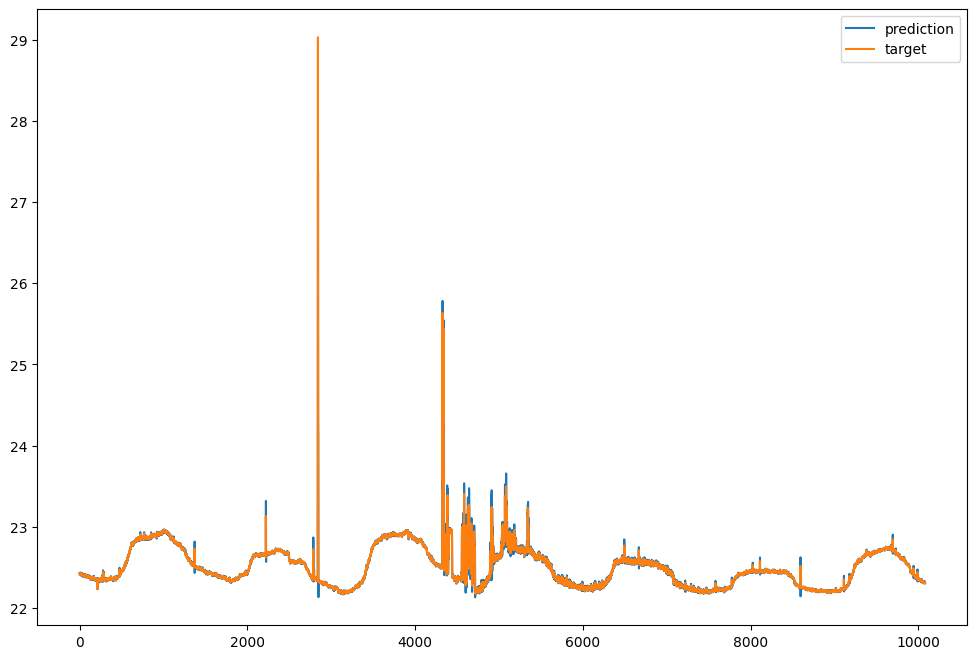

In [73]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

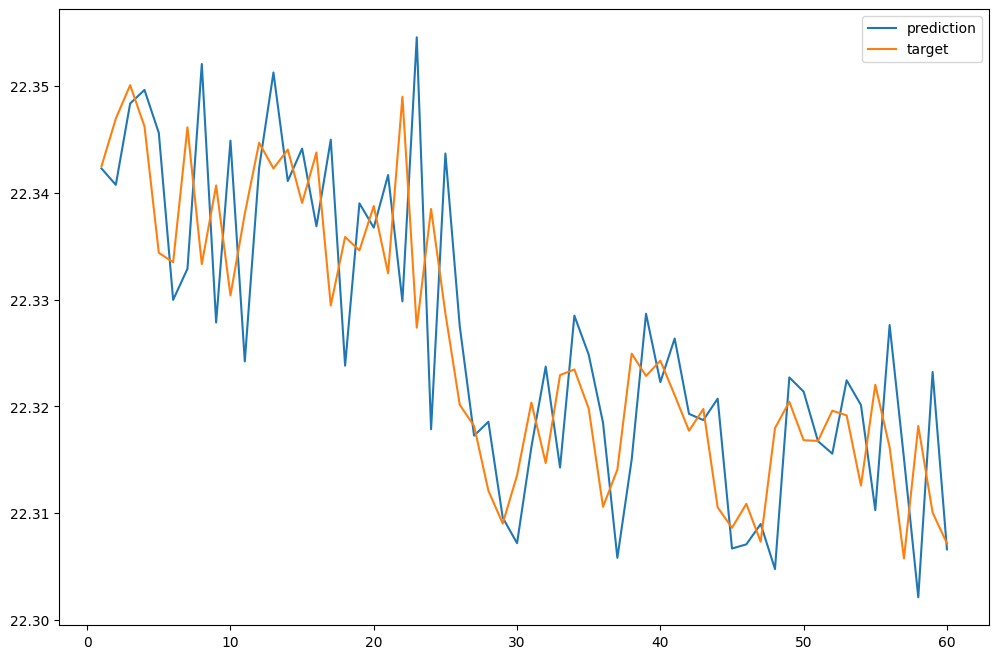

In [74]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [75]:
np.mean(time_list)

0.9577447792603856

1step과 비교했을때level을 맞추면서 sliding을 하게됨

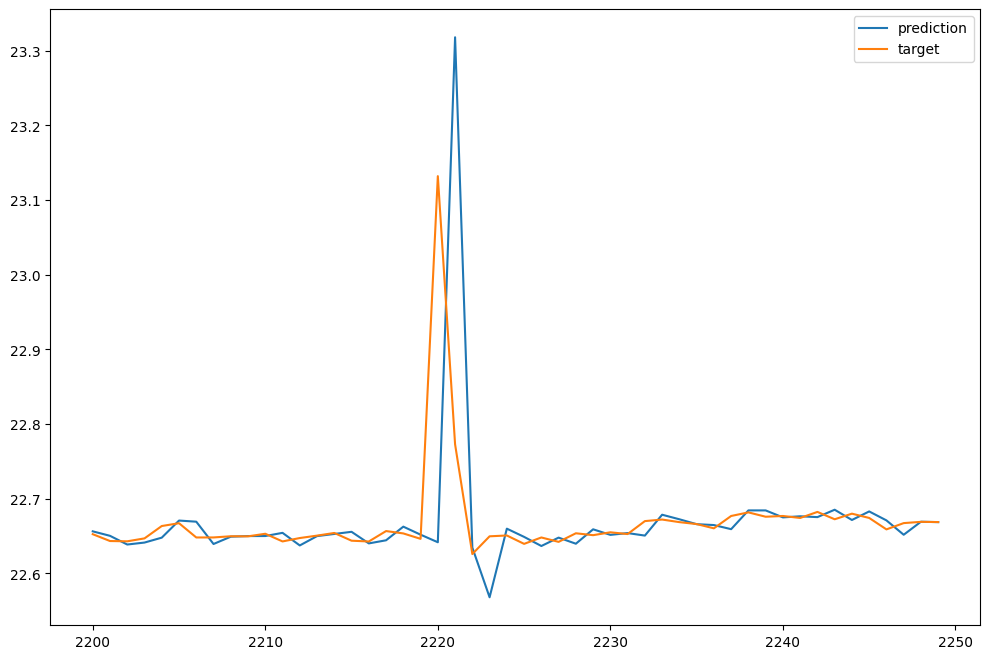

In [76]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()